<a href="https://colab.research.google.com/github/shindeparth007/Gold-Price-Forecasting-ML/blob/main/project_gold_price_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Gold Price Forecasting ML Projet
# Author:Parth Shinde and Chidambar Kulkarni
# Guidance By:Prof. Pragnesh Shah
#Start Date:October 2025
#Description: Complete ML prediction for gold price forecasting using Indian market indicators


# Step 1: IMPORTS AND INITIAL SETUP


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

# Machine Learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.base import clone

# Settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!
🇮🇳 GOLD PRICE FORECASTING WITH INDIAN MARKET INDICATORS
Analysis Date: 2025-10-07 03:13:22


STEP 2: DATA LOADING AND CLEANING

In [ ]:
def load_and_clean_data(csv_file='gold_price_indian_market_data.csv'):
    print("STEP 2: DATA LOADING AND CLEANING")
    print("-" * 40)

    # Load data
    try:
        df = pd.read_csv(csv_file)
        print(f"Data loaded successfully from {csv_file}")
        print(f"Dataset shape: {df.shape}")
    except FileNotFoundError:
        print(f"Error: File '{csv_file}' not found!")
        print(" Please ensure the CSV file is in the same directory in this collab file.")
        return None

    # Convert Date column to datetime
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('Date').sort_index()

    # Display basic info
    print(f"Date range: {df.index[0].date()} to {df.index[-1].date()}")
    print(f"Gold price range: ₹{df['Target_Gold_Price_INR'].min():.2f} - ₹{df['Target_Gold_Price_INR'].max():.2f}")

    # Check for missing values
    missing_values = df.isnull().sum()
    if missing_values.sum() > 0:
        print(f"Missing values found:")
        print(missing_values[missing_values > 0])
        df = df.dropna()
        print(f"After removing missing values: {df.shape[0]} samples")
    else:
        print("No missing values found")

    return df

In [ ]:
# Execute Step 2
df = load_and_clean_data('gold_price_indian_market_data.csv')

# Displaying the first few rows of the cleaned data
if df is not None:
    display(df.head())

STEP 1: DATA LOADING AND CLEANING
----------------------------------------
Data loaded successfully from gold_price_indian_market_data.csv
Dataset shape: (1198, 22)
Date range: 2020-12-02 to 2025-07-04
Gold price range: ₹4192.46 - ₹8727.58
No missing values found


,Gold_Open_INR,Gold_High_INR,Gold_Low_INR,Gold_Close_INR,Gold_Volume,NIFTY_50,India_VIX,INR_Index,USD_INR_Rate,Indian_Bond_10Y,...,Gold_MA_5_INR,Gold_MA_20_INR,Gold_MA_50_INR,Gold_Volatility,Price_Change_Pct,Volume_MA,High_Low_Spread_INR,Open_Close_Change_INR,Target_Gold_Price_INR,Price_Direction
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-02,4307.380123,4310.732980,4277.791425,4333.665913,1713.874338,13838.246124,18.884104,99.856523,74.566341,6.041540,...,4336.292074,4336.292074,4336.292074,3.713953,-0.121051,1361.096844,32.941555,26.285790,4402.711742,Up
2020-12-03,4397.150414,4419.410100,4385.206061,4402.711742,1165.298141,14068.935682,15.266600,101.026375,74.719545,5.998589,...,4358.431964,4358.431964,4358.431964,38.437232,1.593243,1295.830609,34.204039,5.561328,4497.424002,Up
2020-12-04,4475.536321,4497.315221,4473.346162,4497.424002,1284.270133,14247.344232,16.641724,99.422326,74.534353,5.807973,...,4393.179973,4393.179973,4393.179973,76.253812,2.151226,1292.940490,23.969059,21.887681,4299.730885,Down
2020-12-07,4295.180727,4309.393689,4288.758547,4299.730885,1405.574973,14059.577389,26.367260,103.482953,74.235384,5.995286,...,4374.490156,4374.490156,4374.490156,78.150684,-4.395697,1315.467387,20.635141,4.550158,4301.684336,Up
2020-12-08,4306.723425,4325.519299,4285.227819,4301.684336,1652.737438,14066.278378,24.702305,102.098373,74.342334,5.758801,...,4367.043376,4362.355852,4362.355852,75.957036,0.045432,1371.679062,40.291479,-5.039090,4458.061242,Up


# STEP 3: CLASS IMBALANCE CHECK

In [ ]:
#Checking for class imbalance in price direction
def check_class_imbalance(df):
    print("\nSTEP 3: CLASS IMBALANCE CHECK")
    print("-" * 30)

    # Price direction distribution
    direction_counts = df['Price_Direction'].value_counts()
    direction_pct = df['Price_Direction'].value_counts(normalize=True) * 100

    print("Price Direction Distribution:")
    for direction in direction_counts.index:
        count = direction_counts[direction]
        pct = direction_pct[direction]
        print(f"   {direction}: {count} samples ({pct:.1f}%)")

    balance_ratio = direction_counts.min() / direction_counts.max()
    print(f"\nBalance Ratio: {balance_ratio:.3f}")

    if balance_ratio >= 0.3:
        print("CLASSES ARE WELL BALANCED")
        print("No special handling required")
    else:
        print("CLASSES ARE IMBALANCE ")
        print("Need to change,Consider using SMOTE or weighted sampling")

    return balance_ratio

In [ ]:
# Executing Step 3
if df is not None:
    balance_ratio = check_class_imbalance(df)


STEP 3: CLASS IMBALANCE CHECK
------------------------------
Price Direction Distribution:
   Up: 608 samples (50.8%)
   Down: 590 samples (49.2%)

Balance Ratio: 0.970
CLASSES ARE WELL BALANCED
No special handling required


# STEP 4: EXPLORATORY DATA ANALYSIS

In [ ]:
def perform_eda(df):
    """
    Performing comprehensive EDA with 4+ visualizations
    """
    print("\nSTEP 4: EXPLORATORY DATA ANALYSIS")
    print("-" * 35)

    # Visualization 1: Gold Price Time Series with Moving Averages
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    plt.plot(df.index, df['Gold_Close_INR'], label='Gold Close Price', color='gold', linewidth=2)
    plt.plot(df.index, df['Gold_MA_20_INR'], label='MA 20', color='blue', alpha=0.7)
    plt.plot(df.index, df['Gold_MA_50_INR'], label='MA 50', color='red', alpha=0.7)
    plt.title('Gold Price in INR with Moving Averages', fontsize=14, fontweight='bold')
    plt.ylabel('₹ per gram')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Visualization 2: Correlation Heatmap
    plt.subplot(2, 2, 2)
    corr_features = ['Target_Gold_Price_INR', 'NIFTY_50', 'India_VIX', 'USD_INR_Rate',
                    'Indian_Bond_10Y', 'INR_Index', 'Crude_Oil_Brent']
    correlation_matrix = df[corr_features].corr()
    sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
                square=True, cbar_kws={'label': 'Correlation'})
    plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
    plt.tight_layout()

    # Visualization 3: Gold vs NIFTY 50 Relationship
    plt.subplot(2, 2, 3)
    plt.scatter(df['NIFTY_50'], df['Target_Gold_Price_INR'], alpha=0.6, color='green')
    plt.xlabel('NIFTY 50 Index')
    plt.ylabel('Gold Price (₹/gram)')
    plt.title('Gold Price vs NIFTY 50 Correlation', fontsize=14, fontweight='bold')

    z = np.polyfit(df['NIFTY_50'], df['Target_Gold_Price_INR'], 1)
    p = np.poly1d(z)
    plt.plot(df['NIFTY_50'], p(df['NIFTY_50']), "r--", alpha=0.8)
    plt.grid(True, alpha=0.3)

    # Visualization 4: Price Distribution
    plt.subplot(2, 2, 4)
    plt.hist(df['Target_Gold_Price_INR'], bins=50, alpha=0.7, color='gold', edgecolor='black')
    plt.xlabel('Gold Price (₹/gram)')
    plt.ylabel('Frequency')
    plt.title('Gold Price Distribution', fontsize=14, fontweight='bold')
    plt.axvline(df['Target_Gold_Price_INR'].mean(), color='red', linestyle='--',
                label=f'Mean: ₹{df["Target_Gold_Price_INR"].mean():.0f}')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Additional Visualization: India VIX and USD/INR Impact
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.scatter(df['India_VIX'], df['Target_Gold_Price_INR'], alpha=0.6, color='orange')
    plt.xlabel('India VIX')
    plt.ylabel('Gold Price (₹/gram)')
    plt.title('Gold Price vs India VIX (Volatility)', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.scatter(df['USD_INR_Rate'], df['Target_Gold_Price_INR'], alpha=0.6, color='purple')
    plt.xlabel('USD/INR Exchange Rate')
    plt.ylabel('Gold Price (₹/gram)')
    plt.title('Gold Price vs USD/INR Rate', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print key statistics
    print("Key Statistics:")
    print(f"   Average Gold Price: ₹{df['Target_Gold_Price_INR'].mean():.2f}")
    print(f"   Price Volatility (std): ₹{df['Target_Gold_Price_INR'].std():.2f}")
    print(f"   NIFTY 50 Average: {df['NIFTY_50'].mean():.0f}")
    print(f"   India VIX Average: {df['India_VIX'].mean():.1f}")


STEP 4: EXPLORATORY DATA ANALYSIS
-----------------------------------


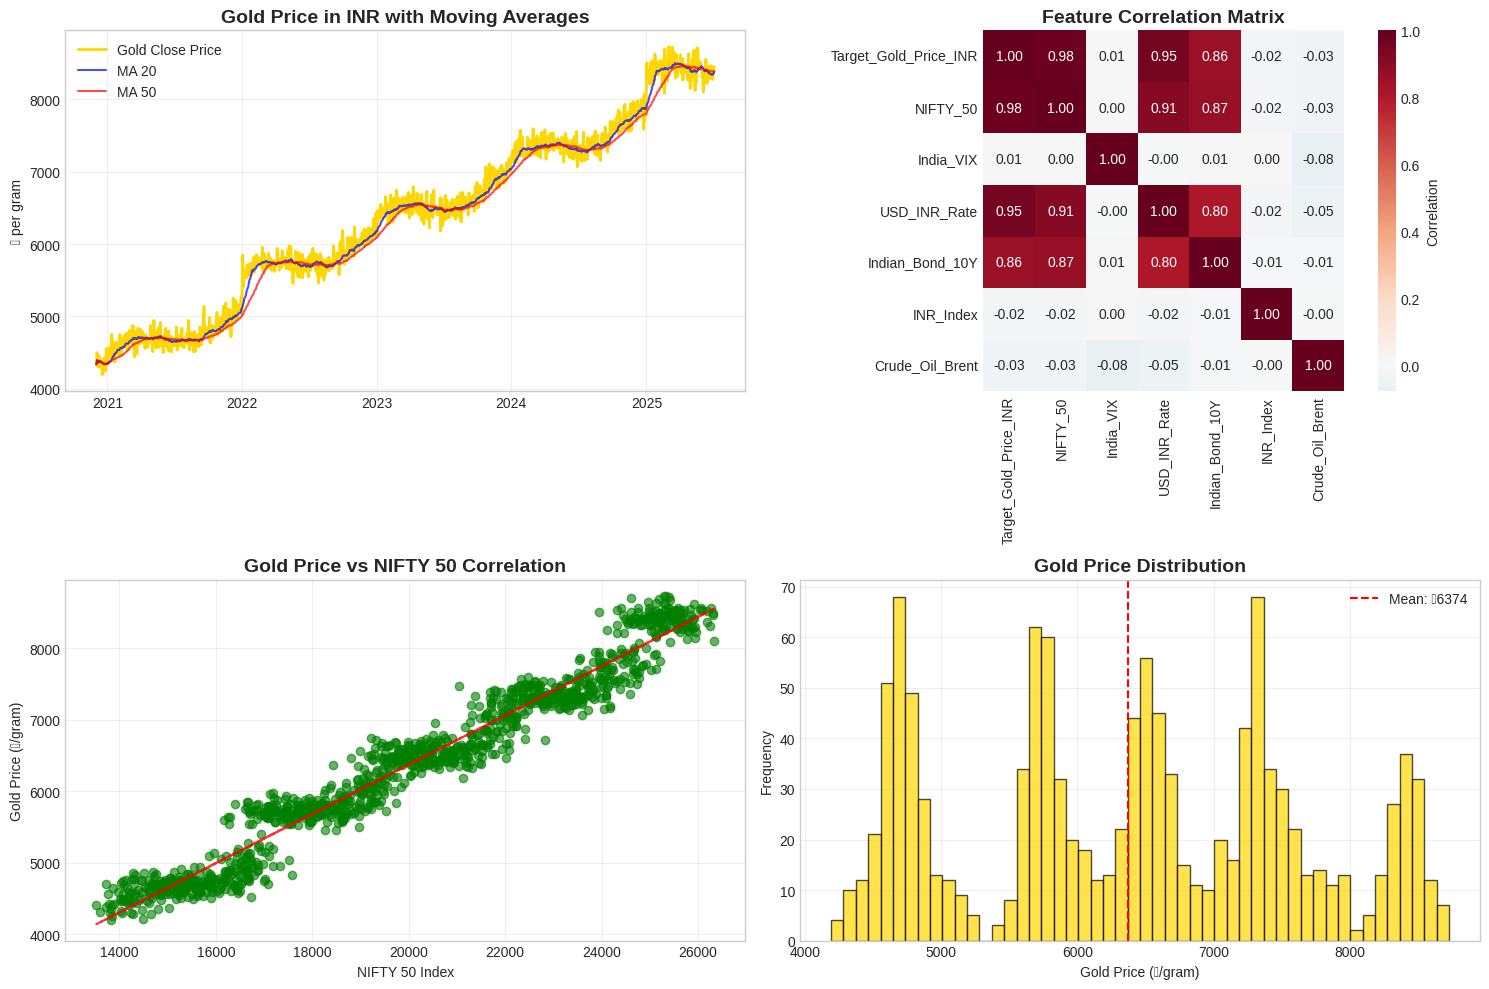

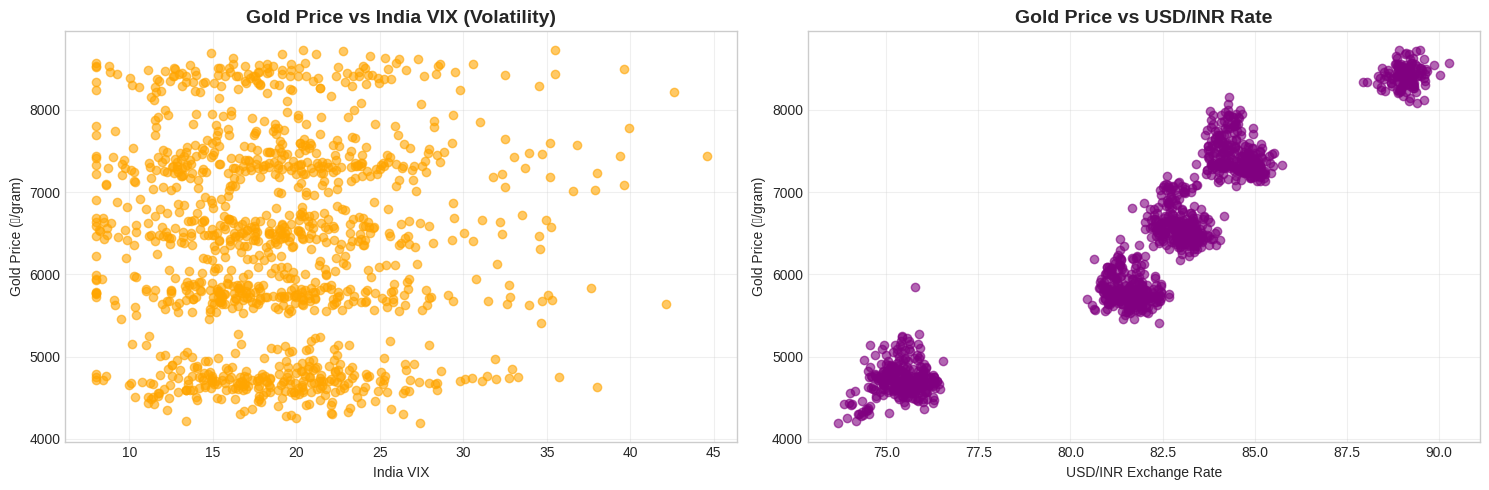

Key Statistics:
   Average Gold Price: ₹6374.38
   Price Volatility (std): ₹1221.14
   NIFTY 50 Average: 20010
   India VIX Average: 19.0


In [ ]:
# Execute Step 3
if df is not None:
    perform_eda(df)